## Key findings and achievements

> * 
> * 

---

## Introduction

Group customers into cohorts and analyze their behaviour over time.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Data

Our dataset is composed by two-year sales data from an online store based in the UK. We first import the data and provide a glimpse of it.

In [2]:
df = pd.read_parquet('../../data/concatenated_online_retail_II.parquet')

df = df.rename(columns={'Customer ID': 'CustomerID'})
df = df.dropna(subset='CustomerID', axis=0)

df['CustomerSince'] = df.groupby('CustomerID')[['InvoiceDate']].transform(min)
df['Lifespan'] =  df['InvoiceDate'] - df['CustomerSince']
df['Lifespan_M'] = (df['Lifespan'].dt.days / 30.44).astype(int)
df['MonthlyCohort'] = pd.to_datetime(df['CustomerSince']).dt.to_period('M') #.dt.to_timestamp()
df['Amount'] = df['Price'] * df['Quantity']

# Mapping regions
regions = {'Europe': ['Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland', 'Netherlands', 'Belgium', 'France', 'Germany', 'Switzerland', 'Austria',
                      'Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Czech Republic', 'Lithuania', 'Poland', 'United Kingdom', 'EIRE',
                      'Channel Islands', 'European Community'],
           'North America': ['USA', 'Canada'],
           'Middle East': ['Bahrain', 'United Arab Emirates', 'Israel', 'Lebanon', 'Saudi Arabia'],
           'Asia Pacific': ['Japan', 'Australia', 'Singapore', 'Hong Kong', 'Korea', 'Thailand'],
           'RoW': ['Brazil', 'RSA', 'West Indies', 'Nigeria', 'Bermuda'],
           'Unspecified': ['Unspecified']}

country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

df['Region'] = df['Country'].map(country_to_region)

df = df[df['Amount'] > 0]

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Year,CustomerSince,Lifespan,Lifespan_M,MonthlyCohort,Amount,Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,83.4,Europe
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,81.0,Europe
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,81.0,Europe
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,100.8,Europe
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,30.0,Europe


## Monthly Cohorts

In [3]:
grouped_m = df.groupby(['MonthlyCohort', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalRevenue=('Amount', 'sum')).reset_index()
grouped_m

,MonthlyCohort,Lifespan_M,n,TotalRevenue
0,2009-12,0,32111,730976.720
1,2009-12,1,13433,403375.071
2,2009-12,2,13449,353813.642
3,2009-12,3,13279,352853.150
4,2009-12,4,14197,337613.590
...,...,...,...,...
314,2011-10,1,2107,26349.110
315,2011-10,2,69,737.210
316,2011-11,0,7014,89903.810
317,2011-11,1,89,4225.350


### Retention

Implementing a cohort analysis is useful for a business to evaluate clients' retention over time. The most common practice is to divide customers according to the period in which they were first acquired (Monthly Cohorts). Based on the available data, we can also divide them by Region.

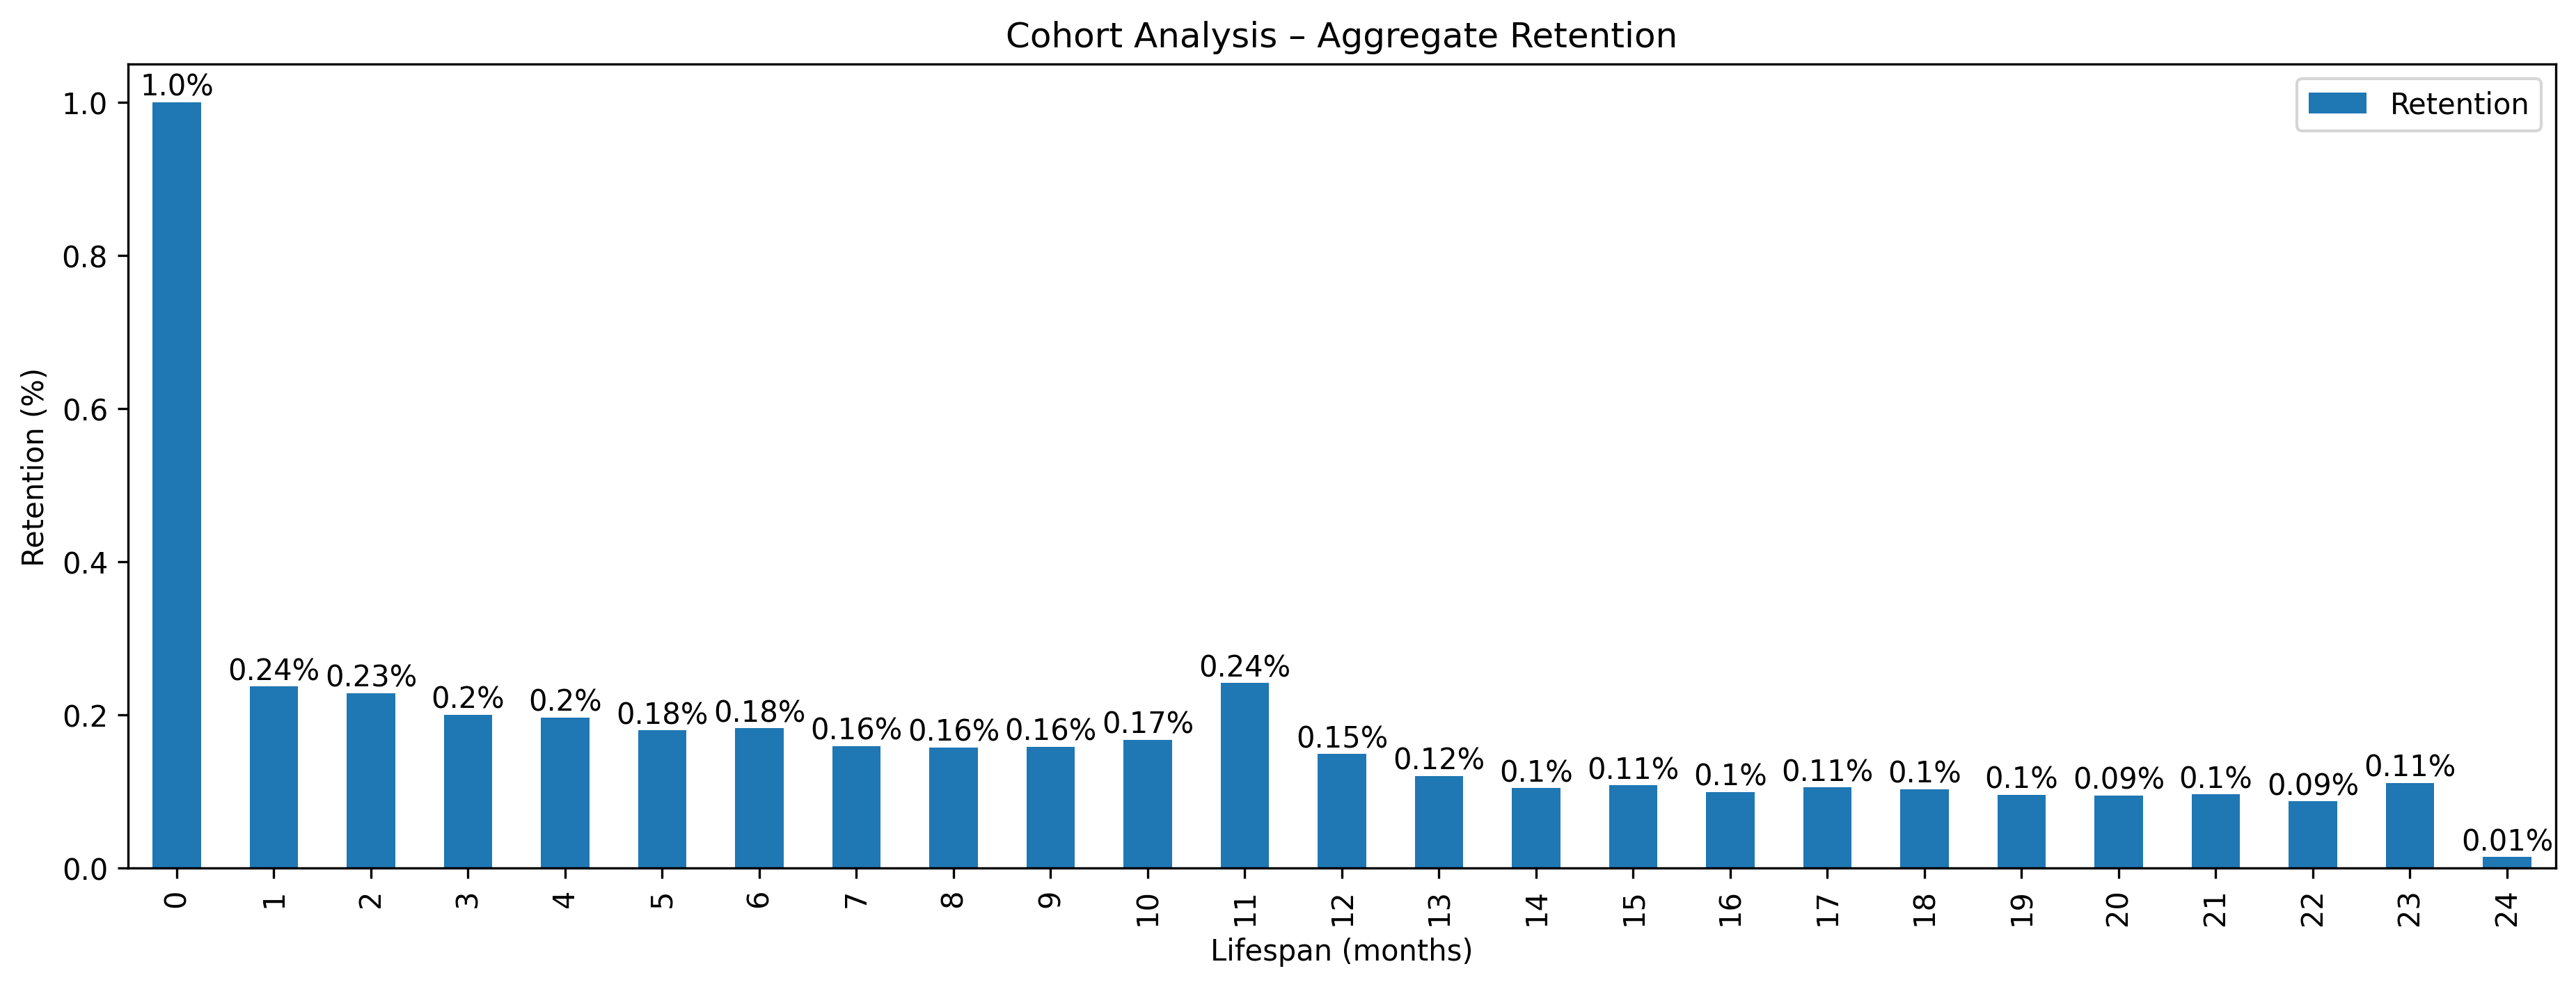

In [4]:
grouped_life_count = df.groupby('Lifespan_M')[['CustomerID']].count()
grouped_life_count = grouped_life_count.divide(grouped_life_count.iloc[0].item(), axis=0)
grouped_life_count = grouped_life_count.rename(columns={'CustomerID': 'Retention'})

fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
grouped_life_count.plot(kind='bar', ax=ax)
for p in ax.patches:
    count = p.get_height().round(2)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 0.02
    ax.annotate(f'{count}%', (x, y), ha='center', va='center')
plt.title("Cohort Analysis – Aggregate Retention")
plt.ylabel('Retention (%)')
plt.xlabel('Lifespan (months)')
plt.show()

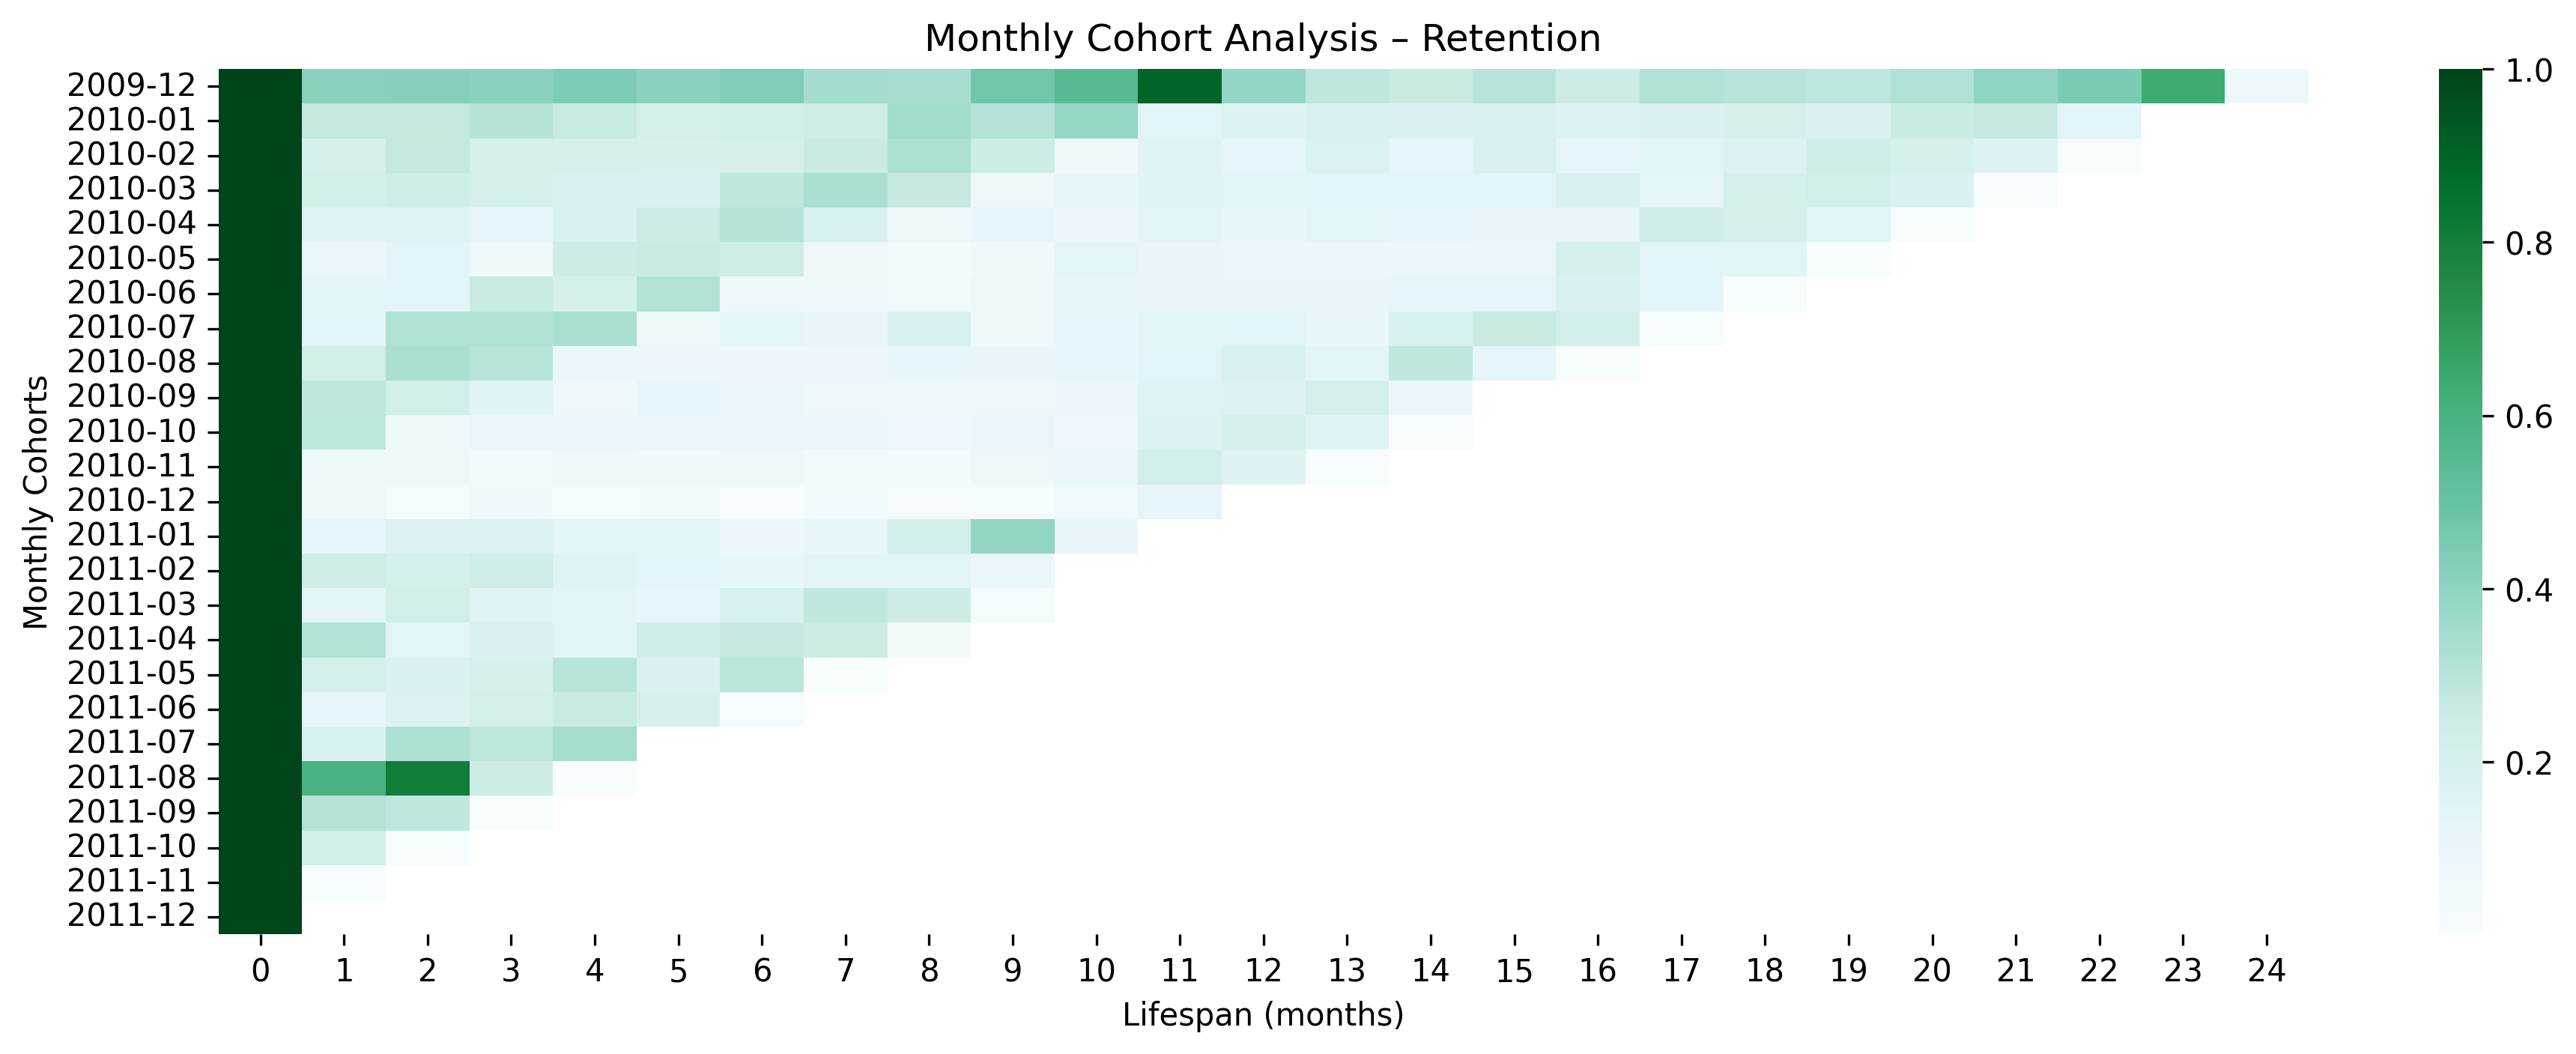

In [5]:
cohorts = grouped_m.reset_index(drop=True).pivot(index='MonthlyCohort', columns='Lifespan_M', values='n')
retention = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(retention, cmap='BuGn')
plt.title("Monthly Cohort Analysis – Retention")
plt.xlabel('Lifespan (months)')
plt.ylabel('Monthly Cohorts')
plt.show()

### Revenue

The same principle could be applied to revenue and average purchase value.

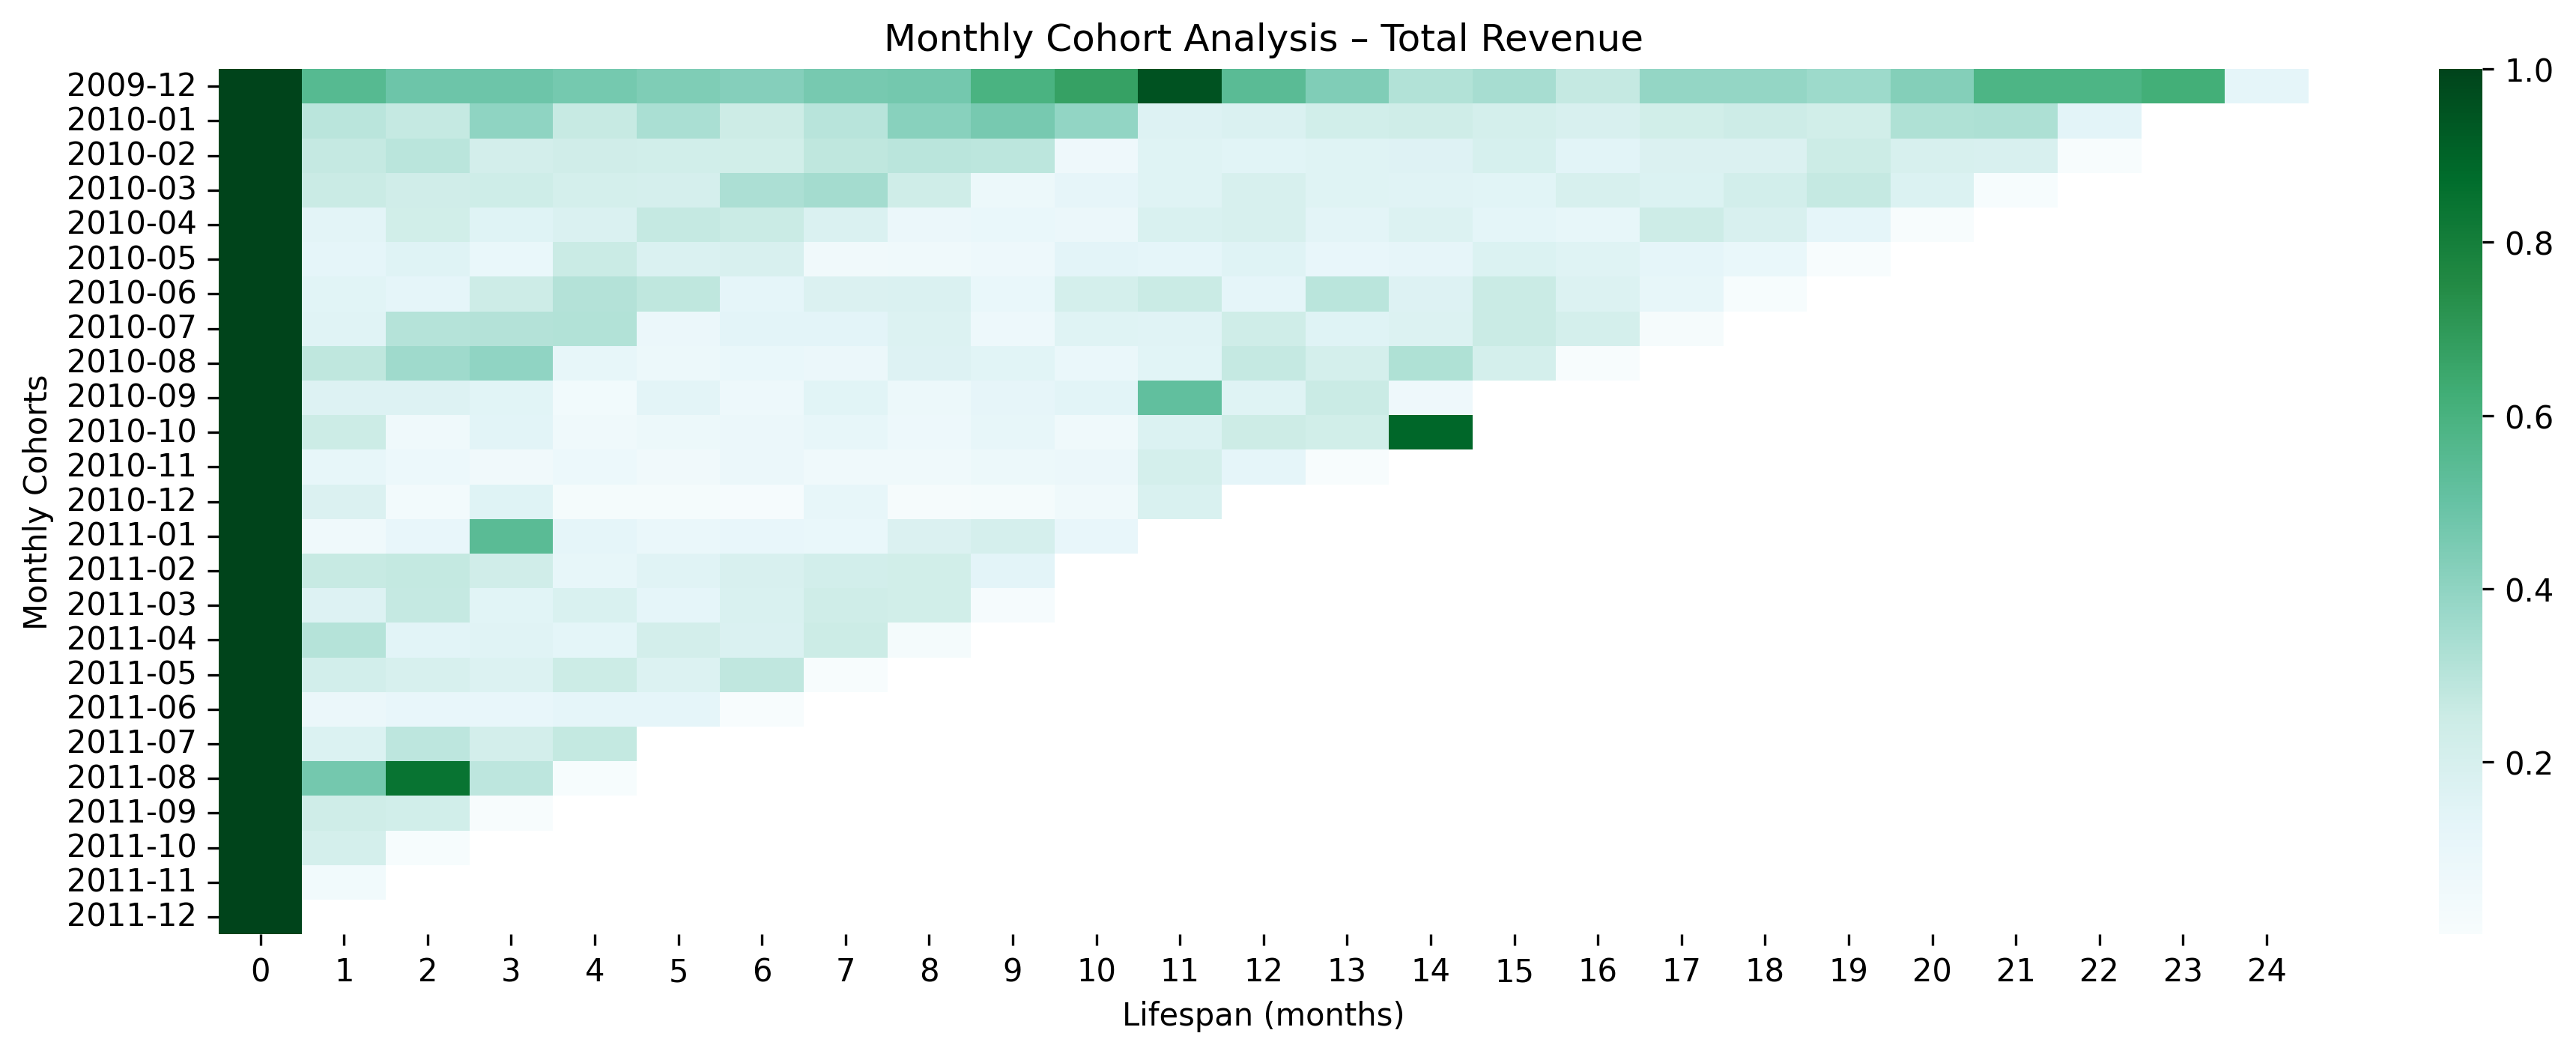

In [6]:
cohorts = grouped_m.reset_index(drop=True).pivot(index='MonthlyCohort', columns='Lifespan_M', values='TotalRevenue')
retention = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(retention, cmap='BuGn')
plt.title("Monthly Cohort Analysis – Total Revenue")
plt.xlabel('Lifespan (months)')
plt.ylabel('Monthly Cohorts')
plt.show()

## Regional Cohorts

In [7]:
grouped_r = df.groupby(['Region', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalRevenue=('Amount', 'sum')).reset_index()
grouped_r

,Region,Lifespan_M,n,TotalRevenue
0,Asia Pacific,0,606,17983.78
1,Asia Pacific,1,120,7324.13
2,Asia Pacific,2,54,3396.66
3,Asia Pacific,3,103,5327.51
4,Asia Pacific,4,236,21895.21
...,...,...,...,...
64,Unspecified,4,41,843.55
65,Unspecified,5,68,2379.88
66,Unspecified,7,76,1387.50
67,Unspecified,15,62,1104.73


## Recency, Frequency and Monetary Value

In [8]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

datamart = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Invoice', 'count'),
    MonetaryValue=('Amount', 'sum')
).reset_index()

datamart['R'] = pd.qcut(datamart['Recency'], q=4, labels=range(4, 0, -1))
datamart['F'] = pd.qcut(datamart['Frequency'], q=4, labels=range(1,5))
datamart['M'] = pd.qcut(datamart['MonetaryValue'], q=4, labels=range(1,5))
datamart['RFM_Segment'] = datamart.apply(
    lambda row: 
        str(row['R'].astype(int)) + 
        str(row['F'].astype(int)) + 
        str(row['M'].astype(int)), 
        axis=1)
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)
datamart

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,326,34,77556.46,2,2,4,224,8
1,12347.0,2,253,5633.32,4,4,4,444,12
2,12348.0,75,51,2019.40,3,2,3,323,8
3,12349.0,19,175,4428.69,4,4,4,444,12
4,12350.0,310,17,334.40,2,1,1,211,4
...,...,...,...,...,...,...,...,...,...
5873,18283.0,4,986,2736.65,4,4,4,444,12
5874,18284.0,432,28,461.68,1,2,2,122,5
5875,18285.0,661,12,427.00,1,1,2,112,4
5876,18286.0,477,67,1296.43,1,3,3,133,7


In [9]:
datamart.groupby('RFM_Segment')\
    .size()\
        .sort_values(ascending=False)[:10]

RFM_Segment
444    628
111    564
344    332
211    290
333    246
233    243
122    241
222    234
433    196
322    184
dtype: int64

In [10]:
datamart.groupby('RFM_Score').agg(
    n=('CustomerID', 'count'),
    AvgRecency=('Recency', 'mean'),
    AvgFrequency=('Frequency', 'mean'),
    AvgMonetaryValue=('MonetaryValue', 'mean')).round(1).sort_index(ascending=False)

,n,AvgRecency,AvgFrequency,AvgMonetaryValue
RFM_Score,,,,
12,628,10.4,579.9,14892.4
11,542,35.9,275.5,5029.5
10,548,70.1,177.9,3139.0
9,563,97.7,112.7,2464.3
8,622,147.5,74.7,1473.1
7,631,198.5,52.5,1119.0
6,603,224.8,34.2,698.9
5,620,311.3,25.2,438.7
4,557,377.3,17.5,255.3
